# Urgency Speech Recognition for Hospital Calls
### Author : Jad El Karchi

### Imports

In [99]:
import torch
import librosa
import pandas as pd
import time
from io import BytesIO
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
from pydub import AudioSegment
import numpy as np
from scipy.signal import butter, lfilter
import wave
import seaborn as sns
import matplotlib.pyplot as plt
from pydub import AudioSegment
from src.model import AudioUrgencyModel, text_classifier, S2T_model, S2T_processor, device
import numpy as np

## 1: Record audio & Save it

In [84]:
freq = 16000
duration = 20
audio_filename = "audio/recording0.wav"

In [115]:
recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=2)
sd.wait()

In [116]:
write(audio_filename, freq, recording)
sd.play(recording, freq)

In [ ]:
def load_audio(file_path, sr):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def time_stretch(audio, rate=1.2):
    return librosa.effects.time_stretch(audio, rate=rate)

def add_noise(audio, noise_level=0.005):
    noise = np.random.normal(noise_level - 0.005, noise_level, audio.shape)
    return audio + noise

def extract_audio_features(audio, freq):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=freq)
    pitch = np.mean(pitches[pitches > 0])
    
    mfccs = librosa.feature.mfcc(y=audio, sr=freq, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    return pitches, pitch, mfccs_mean


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [123]:

audio, sr = load_audio(audio_filename, freq)
audio_stretched = time_stretch(audio, rate=1)
audio_noisy = add_noise(audio_stretched, noise_level=0.01)
audio_equalized = bandpass_filter(audio_noisy, 300, 3500, freq)

sd.play(audio_equalized, sr)

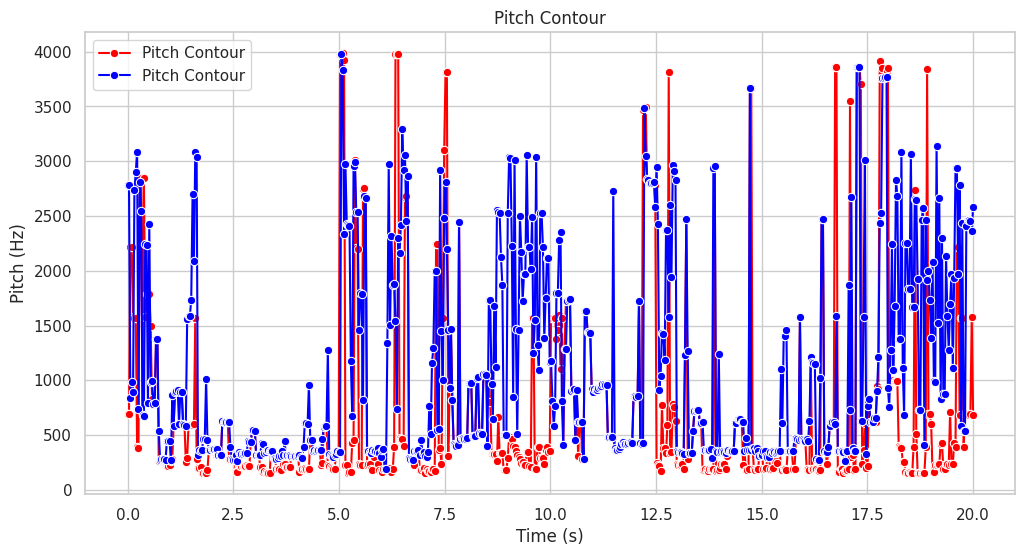

In [124]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

for audio, color in zip([audio, audio_equalized], ['red', 'blue']):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=freq)

    pitch_values = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch_values.append(pitches[index, t] if pitches[index, t] > 0 else np.nan)

    time = np.linspace(0, len(audio) / sr, num=len(pitch_values))
    df = pd.DataFrame({'Time (s)': time, 'Pitch (Hz)': pitch_values})

    sns.lineplot(data=df, x='Time (s)', y='Pitch (Hz)', marker='o', color=color, label='Pitch Contour')

# Customize plot
plt.title('Pitch Contour')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.savefig('plots/pitch_contour.png')


In [93]:
def transcribe_audio(segment, model, processor, sampling_rate=16000):
    # Load audio file
    audio_data = np.array(segment).astype(np.float32) / 2**15
    
    # Process the audio
    inputs = processor(audio_data, sampling_rate=sampling_rate, return_tensors="pt")

    # Generate transcription (send data to GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_features"], attention_mask=inputs["attention_mask"])
    
    # Decode transcription
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return transcription

audio_model = AudioUrgencyModel().to(device)

def analyze_urgency(audio, transcript_text):
    # Extract audio features
    y, sr = librosa.load(audio, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Convert to tensor for model input
    audio_input = torch.tensor(mfcc_mean).unsqueeze(0).float()
    
    # Predict audio urgency
    audio_model.eval()
    with torch.no_grad():
        audio_urgency_score = audio_model(audio_input).item()
    
    # Predict text urgency using sentiment analysis
    text_result = text_classifier(transcript_text)[0]
    text_urgency_score = 1 if text_result['label'] == 'LABEL_1' else 0  # Adjust labels based on sentiment model output
    
    # Combine scores
    final_urgency_score = 0.6 * audio_urgency_score + 0.4 * text_urgency_score
    
    return final_urgency_score

In [91]:
transcribe_audio(audio, S2T_model, S2T_processor)

"i thought can be used to perform a variety of tasks one of them is creating a voice recorder we can use python's sound device more due to record and play audio"